# CorrSeg

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path

# sklearn
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut, cross_val_score, TimeSeriesSplit, train_test_split

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import models, datasets
from torchvision.transforms import v2

### Loading data

                  0  1  2  3  4  5  6  7  8  9  ...  1286  1287  1288  1289  \
well_10_patch_0   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_1   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_10  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_11  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_12  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...              .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
well_15_patch_95  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_96  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_97  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_98  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_99  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

                  1290  1291  1292  1293  1294  129

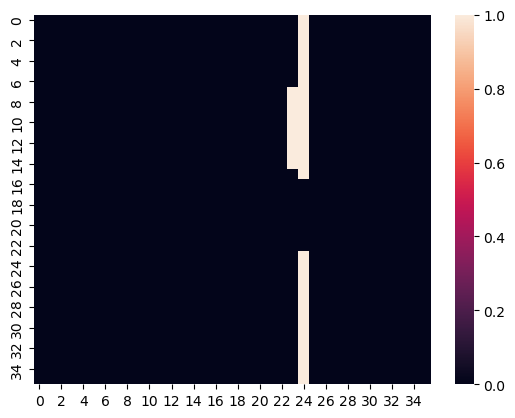

In [6]:
# Read file
y_train = pd.read_csv('./y_train_PlZf4rH.csv', index_col=0) #Table with index being the name of the patch
print(y_train)
y_1_130 = np.array(y_train.loc['well_1_patch_130'])

# Access to one patch label
sns.heatmap(np.array(y_train.loc['well_1_patch_40']).reshape(36, 36))
print(np.array(y_train.loc['well_1_patch_126']).reshape(36, 36))

# Get all labels at once
# y_train.values.reshape((-1,36,36))

In [8]:
path = Path('./images')
image_paths = np.array([x for x in path.iterdir()])
image_names = np.array([str(x).split('/')[1].split('.')[0] for x in image_paths]) # extracting image path names into a list in order to reindex labels
n = len(image_paths)
images_array = np.empty((n, 36, 36), dtype=np.float32)

for i, path in enumerate(image_paths):
    if path != image_paths[i]: 
        print('chaos')
    # print("at ", i, "of", n)
    images_array[i] = np.load(path)


In [9]:
labels = y_train.reindex(image_names)
print(labels.shape)

(9674, 1296)


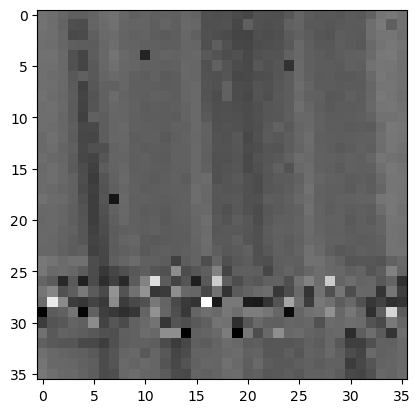

In [10]:
plt.imshow(images_array[9] * 255, cmap='gray')

In [11]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


## EDA

In [12]:
def plot_mask_and_image(img, label):    
    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    print(type(x))
    print(x.shape)

    sns.heatmap(label, ax=axes[0])
    axes[0].set_title('Heatmap')
    axes[0].set_aspect('equal')

    axes[1].imshow(img, cmap='gray')
    axes[1].set_title('Image')

    plt.tight_layout()

In [13]:
def plot_two_images(x1, x2):

    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    print(np.unique(x1))

    axes[0].imshow(x1, cmap='gray')
    axes[0].set_title('Image OG')
    axes[0].set_aspect('equal')

    axes[1].imshow(x2, cmap='gray')
    axes[1].set_title('Image Flip')
    axes[0].set_aspect('equal')

    plt.tight_layout()

In [ ]:
well_patch = 'well_1_patch_135'

plot_mask_and_image(x.cpu(), np.array(y_train.loc[well_patch]).reshape(36, 36))

sns.displot(x.reshape(-1))
print(x[32, 30])

In [14]:
print(np.unique(images_array))
# np.equal(images, nan)
np.argwhere(images_array == np.nan)

[-9.9925000e+02 -9.9900000e+02 -9.3992406e-01 ...  4.2167890e-01
  4.7034341e-01            nan]


array([], shape=(0, 3), dtype=int64)

In [15]:
np.min(images_array)

nan

## Preprocessing

In [16]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
images_array_imp = imputer.fit_transform(images_array.reshape(n, 36*36)).reshape(n, 36, 36)

In [280]:
# leaving outliers for now, using robust scaler
scaler = RobustScaler()
for i, image in enumerate(images_array_imp):
    scaler.fit_transform(image)

/Users/Andrej/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/Andrej/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/Andrej/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <B2020C3B-209A-3D8E-86A7-CC634C84A0EF> /Users/Andrej/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/Andrej/anaconda3/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. Whil

In [18]:
labels = y_train.reindex(image_names)
flip_amount = len(labels) # 4000

In [19]:
in_img = torch.tensor(images_array_imp[:flip_amount], dtype=torch.float32, device=mps_device)
in_labels = torch.tensor(labels[:flip_amount].values.reshape(-1, 36, 36), dtype=torch.float32, device=mps_device)

#### Horizontsl Flip

In [23]:
transform = v2.Compose([
    v2.RandomHorizontalFlip(p=1),
])

out_img = transform(in_img)
out_labels = transform(in_labels)

print(out_img.shape)
print(out_labels.shape)

img_aug = torch.concat([in_img, out_img], 0)
labels_aug = torch.concat([in_labels, out_labels], 0)
img_aug.shape

torch.Size([9674, 36, 36])
torch.Size([9674, 36, 36])


torch.Size([19348, 36, 36])

#### Vertical Flip

In [38]:
transform = v2.Compose([
    v2.RandomVerticalFlip(p=1),
])
flip_amount = len(labels) # 4000
out_img = transform(in_img).to(mps_device)
out_labels = transform(in_labels).to(mps_device)

print(out_img.shape)
print(out_labels.shape)

img_aug = torch.concat([img_aug, out_img], 0)
labels_aug = torch.concat([labels_aug, out_labels], 0)

img_aug.shape
labels_aug.shape

torch.Size([9674, 36, 36])
torch.Size([9674, 36, 36])


torch.Size([29022, 36, 36])

#### Rotation 

In [17]:
transform = v2.Compose([
    v2.RandomRotation(degrees=90),
])
flip_amount = len(labels) # 4000
out_img = transform(in_img).to()
out_labels = transform(in_labels).to()

print(out_img.shape)
print(out_labels.shape)

img_aug = torch.concat([img_aug, out_img], 0)
labels_aug = torch.concat([labels_aug, out_labels], 0)

img_aug.shape
labels_aug.shape

torch.Size([9674, 36, 36])
torch.Size([9674, 36, 36])


torch.Size([38696, 36, 36])

[-0.04917306 -0.047216   -0.04526222 ...  0.02709413  0.02773702
  0.03081495]


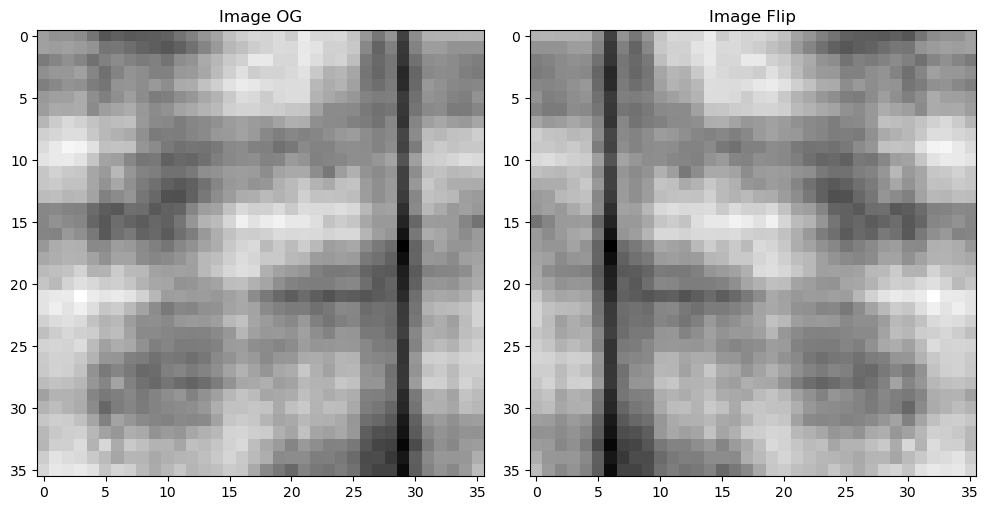

In [24]:
in_img[0]
id = 486

plot_two_images(in_img[id].cpu(), out_img[id].cpu())

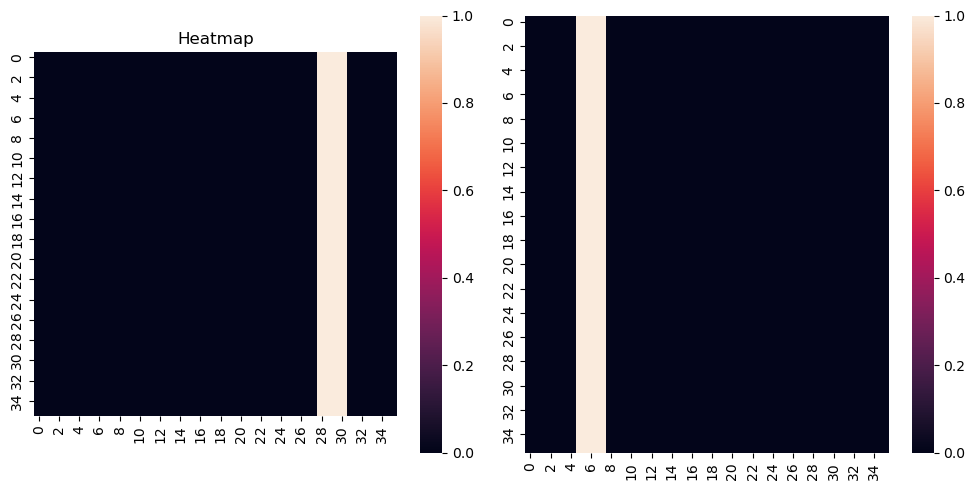

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(np.array(in_labels[id].cpu()).reshape(36, 36), ax=axes[0])
axes[0].set_title('Heatmap')
axes[0].set_aspect('equal')

sns.heatmap(np.array(out_labels[id].cpu()).reshape(36, 36), ax=axes[1])
axes[0].set_title('Heatmap')
axes[0].set_aspect('equal')

plt.tight_layout()

### Data augmentation

## Pipeline

In [29]:
torch.manual_seed(12)  # For reproducibility
indices = torch.randperm(len(labels))
print(indices[:10])

tensor([6781, 5987, 8880, 1142, 3557,  805, 4077, 2260, 1980, 7639])


In [302]:
labels = y_train.reindex(image_names)
X_tensor = torch.tensor(images_array_imp, dtype=torch.float32, device=mps_device)
y_tensor = torch.tensor(labels.values.reshape(-1, 36, 36), dtype=torch.float32, device=mps_device)

In [303]:
print(np.unique(indices).shape)

(9674,)


In [304]:
for tens in X_tensor:
    if tens.max() == 1:
        print(tens)

for tens in X_tensor[indices]:
    if tens.max() == 1:
        print(tens)

X_tensor[indices]

tensor([[[ 2.3384e-03,  5.3495e-05,  2.1594e-03,  ...,  4.9010e-03,
          -6.2555e-04,  1.0267e-03],
         [-2.4471e-04,  2.2434e-03,  1.6045e-03,  ..., -1.0797e-02,
          -9.0716e-03, -5.5042e-03],
         [-9.3013e-04,  9.1091e-04,  1.2025e-04,  ..., -6.7520e-03,
          -9.7433e-03, -5.5894e-04],
         ...,
         [ 1.1008e-02,  2.0398e-03, -7.0530e-04,  ...,  9.4845e-03,
           1.9780e-02,  2.2470e-02],
         [ 4.2647e-03,  5.4350e-03,  2.4786e-03,  ...,  1.2517e-02,
           8.6150e-03,  3.0570e-03],
         [-1.6843e-02, -1.4508e-02, -1.0942e-02,  ...,  5.0935e-03,
          -4.1750e-03, -9.9195e-03]],

        [[-6.1916e-03, -2.5377e-03,  1.0390e-03,  ..., -3.6007e-04,
          -2.7484e-03, -4.0270e-03],
         [-8.2402e-03, -5.9060e-03, -1.9771e-03,  ..., -3.4710e-03,
          -5.6928e-03, -6.1669e-03],
         [-6.5391e-03, -6.8087e-03, -1.5444e-03,  ..., -2.9631e-03,
          -6.9525e-03, -6.1045e-03],
         ...,
         [ 1.2396e-02,  3

In [305]:
print(labels.shape)
id = 89
# plt.imshow(images[id] * 255)

cutoff = int(len(labels) * 0.8)
print("images: ", images_array_imp.shape)
X_train = X_tensor[:cutoff]
X_val = X_tensor[cutoff:]
print("x shape", X_train.shape)

y_training = y_tensor[:cutoff]
y_val = y_tensor[cutoff:]

train_set = torch.utils.data.TensorDataset(
    X_train,
    y_training)
val_set = torch.utils.data.TensorDataset(
    X_val, 
    y_val)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

(9674, 1296)
images:  (9674, 36, 36)
x shape torch.Size([7739, 36, 36])


In [30]:
indices = torch.randperm(len(img_aug))

img_shuffle = img_aug[indices]
print(indices[:10])
# labels_aug = labels_aug[indices]
labels_shuffle = labels_aug[indices]
id
print(img_aug[indices[485]])
print(img_shuffle[485])

for tens in out_img:
    if tens.max() == 1:
        print(tens)

for tens in img_shuffle:
    if tens.max() == 1:
        print(tens)


tensor([13771,    18,  5634, 16616, 19077,   397, 14197,  6609, 14321, 17463])
tensor([[-5.8084e-03,  1.0269e-03,  9.1938e-03,  ..., -3.1918e-04,
         -1.8725e-03, -5.5075e-03],
        [-7.6696e-03, -3.7551e-05,  3.4324e-03,  ..., -1.3467e-03,
         -2.8786e-03, -6.3055e-03],
        [-6.7384e-03, -9.9617e-04,  7.8048e-03,  ..., -1.1399e-03,
         -4.8580e-03, -7.7617e-03],
        ...,
        [-3.7882e-03, -6.4089e-03, -1.0216e-02,  ...,  1.0296e-02,
          6.5787e-03,  4.4246e-03],
        [-4.5193e-03, -6.3864e-03, -6.0679e-03,  ...,  4.1615e-03,
          5.8221e-03,  3.7807e-04],
        [ 4.0662e-04, -1.3290e-03, -3.9814e-03,  ...,  1.8500e-03,
          3.7696e-03,  4.4025e-03]], device='mps:0')
tensor([[-5.8084e-03,  1.0269e-03,  9.1938e-03,  ..., -3.1918e-04,
         -1.8725e-03, -5.5075e-03],
        [-7.6696e-03, -3.7551e-05,  3.4324e-03,  ..., -1.3467e-03,
         -2.8786e-03, -6.3055e-03],
        [-6.7384e-03, -9.9617e-04,  7.8048e-03,  ..., -1.1399e-03,


tensor([-9.9900e+02, -1.0565e-01, -1.0060e-01,  ...,  1.0866e-01,
         1.2864e-01,  1.3958e-01], device='mps:0')
[-9.9900000e+02 -1.0565233e-01 -1.0059687e-01 ...  1.0865831e-01
  1.2863642e-01  1.3958228e-01]


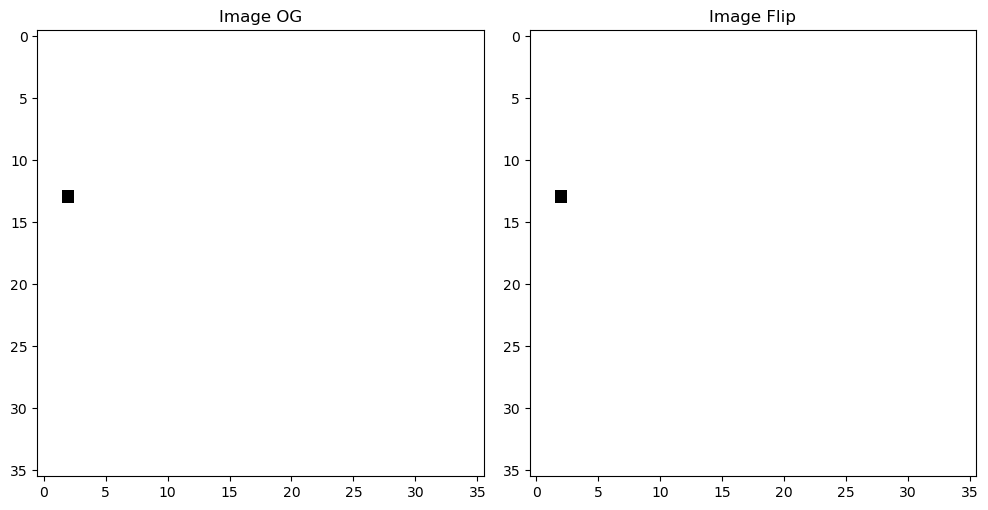

In [35]:
id = 1965
print(img_aug[indices[id]].unique())
plot_two_images(img_aug[indices[id]].cpu(), img_shuffle[id].cpu())

<class 'torch.Tensor'>
torch.Size([1])


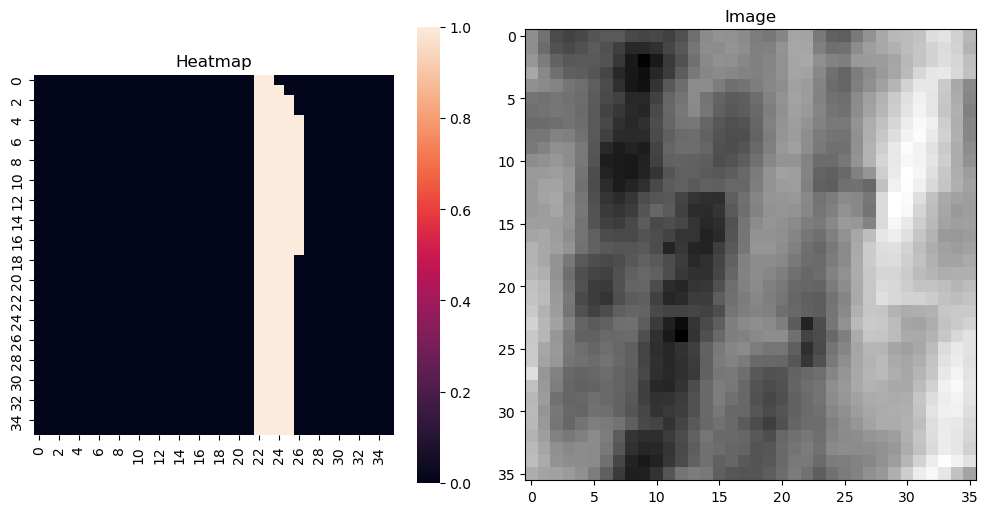

In [39]:
id = 1951
plot_mask_and_image(img_shuffle[id].cpu(), labels_shuffle[id].cpu())

In [40]:
cutoff = int(len(img_shuffle) * 0.8)
train_set = torch.utils.data.TensorDataset(
    img_shuffle[:cutoff], 
    labels_shuffle[:cutoff])
val_set = torch.utils.data.TensorDataset(
    img_shuffle[cutoff:], 
    labels_shuffle[cutoff:])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)

## CNN

In [45]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Encoding
        self.conv0 = nn.Conv2d(1, 32, 3, padding=1, bias=False)
        self.conv1 = nn.Conv2d(32, 32, 3, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=False)

        # Decoding
        self.deconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2, bias=False)
        self.conv3 = nn.Conv2d(32, 1, 1, bias=False)

    def forward(self, x):
        # print("x", x.shape)
        # Encoder
        x0 = F.relu(self.conv0(x))
        x1 = F.relu(self.conv1(x0))
        # print("x1", x1.shape)
        x2 = F.relu(self.conv2(x1))
        # print("x2", x2.shape)

 
        # Decoder
        x = F.relu(self.deconv1(x2))
        # print("x3", x.shape)
        x = F.relu(self.deconv1(torch.cat([x1, x], 1)))
        # print("new ", x.shape)


        # print("sending", type(self.conv3(x)))
        #output
        # print(self.conv3(x))
        x = torch.sigmoid(self.conv3(x))
        
        return x

In [46]:
model = CNN()

In [47]:
from torchsummary import summary

summary(model, input_size=(1, 36, 36))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            288
├─Conv2d: 1-2                            9,216
├─Conv2d: 1-3                            18,432
├─ConvTranspose2d: 1-4                   8,192
├─Conv2d: 1-5                            32
Total params: 36,160
Trainable params: 36,160
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            288
├─Conv2d: 1-2                            9,216
├─Conv2d: 1-3                            18,432
├─ConvTranspose2d: 1-4                   8,192
├─Conv2d: 1-5                            32
Total params: 36,160
Trainable params: 36,160
Non-trainable params: 0

In [49]:
from torchmetrics import JaccardIndex

def jaccard_loss(y_true, y_pred, smooth=100.0):
    intersection = torch.sum( y_true * y_pred, axis=-1)
    union = torch.sum(y_true + y_pred, axis=-1) - intersection
    jac = (intersection + smooth) / (union + smooth)
    return (1 - jac) * smooth


len loader 121
Epoch [1/3000], Loss: 0.6904, Val Loss: 0.6881
Epoch [2/3000], Loss: 0.6873, Val Loss: 0.6843
Epoch [3/3000], Loss: 0.5930, Val Loss: 0.5986
Epoch [4/3000], Loss: 0.3862, Val Loss: 0.4165
Epoch [5/3000], Loss: 0.3499, Val Loss: 0.4071
Epoch [6/3000], Loss: 0.3575, Val Loss: 0.4015
Epoch [7/3000], Loss: 0.3889, Val Loss: 0.3978
Epoch [8/3000], Loss: 0.3717, Val Loss: 0.3965
Epoch [9/3000], Loss: 0.3602, Val Loss: 0.3841
Epoch [10/3000], Loss: 0.3057, Val Loss: 0.3706
Epoch [11/3000], Loss: 0.2982, Val Loss: 0.3607
Epoch [12/3000], Loss: 0.3458, Val Loss: 0.3512
Epoch [13/3000], Loss: 0.2864, Val Loss: 0.3421
Epoch [14/3000], Loss: 0.3015, Val Loss: 0.3321
Epoch [15/3000], Loss: 0.2936, Val Loss: 0.3233
Epoch [16/3000], Loss: 0.2372, Val Loss: 0.3152
Epoch [17/3000], Loss: 0.2526, Val Loss: 0.3078
Epoch [18/3000], Loss: 0.2611, Val Loss: 0.3020
Epoch [19/3000], Loss: 0.3232, Val Loss: 0.2967
Epoch [20/3000], Loss: 0.2934, Val Loss: 0.2919
Epoch [21/3000], Loss: 0.2400, Val

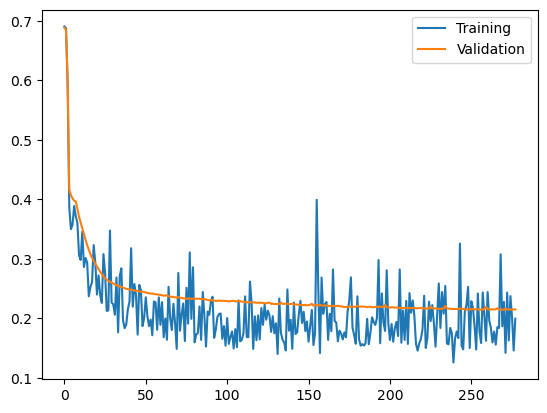

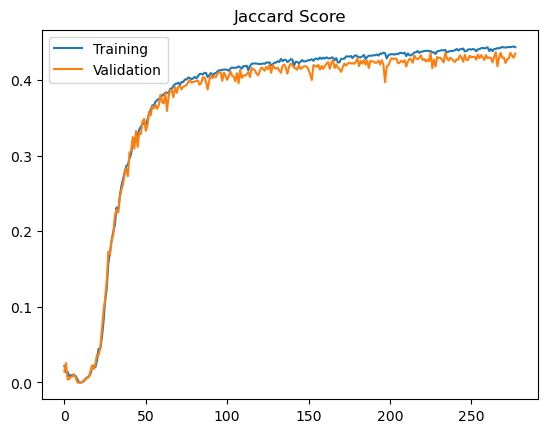

In [50]:
# Instantiate the model
model = CNN()
model.to(mps_device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 3000
loss_scores = []
val_loss_scores = []
jacc_scores = []
val_jacc_scores = []
print("len loader", len(train_loader))
jaccard = JaccardIndex(task='binary').to(mps_device)
for epoch in range(num_epochs):
    model.train()
    jacc_score = 0
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images.unsqueeze(1))
        loss = criterion(outputs, labels.unsqueeze(1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        jacc_score += jaccard(outputs, labels.unsqueeze(1))
        
    # Validation loop
    model.eval()
    val_loss = 0
    val_jacc_score = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1) # adding a dimention for the channel
            labels = labels.unsqueeze(1) # adding a dimention for the channel
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            # Jaccard
            val_jacc_score += jaccard(outputs, labels).cpu()
    
    # jacc_scores.append(jacc_score)
    loss_scores.append(loss.item())
    jacc_scores.append(jacc_score.cpu()/len(train_loader))
    val_loss_scores.append(val_loss/len(val_loader))
    val_jacc_scores.append(val_jacc_score.cpu()/len(val_loader))

    # CHECKPOINT
    if epoch > 600 and epoch % 50 == 0:
        torch.save(model.state_dict(), f'trained_model_e:{epoch}_checkpoint.pth')



    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

    if epoch < 100:
        continue
    # CHECK LOSS DESCENT
    elif np.sum(val_loss_scores[-20:]) > np.sum(val_loss_scores[-40:-20]):
        print(f"checked {np.sum(val_loss_scores[-20:])} with {np.sum(val_loss_scores[-40:-20])}")
        torch.save(model.state_dict(), f'trained_model_e:{epoch}_critical.pth')
        break

torch.save(model.state_dict(), f'trained_model_e:{epoch}_{time.localtime()}.pth')


plt.plot(loss_scores)
plt.plot(val_loss_scores)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(jacc_scores)
plt.plot(val_jacc_scores)
plt.title('Jaccard Score')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()


In [51]:
print(val_loss_scores[-10:])
print(val_loss_scores[-20:-10])

[0.21523091290146112, 0.2146867336705327, 0.21458817925304174, 0.2161711137741804, 0.21496035158634186, 0.21503861248493195, 0.21519787050783634, 0.21474437601864338, 0.21510600671172142, 0.21510935854166746]
[0.21527722291648388, 0.2194099146872759, 0.21558283548802137, 0.21572839841246605, 0.21494025643914938, 0.21576989255845547, 0.21473161783069372, 0.21541745867580175, 0.21702982857823372, 0.21478185802698135]


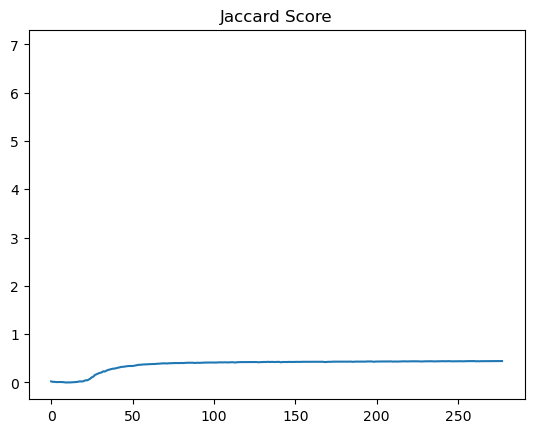

<Figure size 640x480 with 0 Axes>

In [52]:
# jacc_scores = np.array([score.cpu() for score in jacc_scores])
# val_jacc_scores = [score.cpu() for score in val_jacc_scores]

plt.plot(jacc_scores)
plt.plot(val_jacc_score)
plt.title('Jaccard Score')
plt.show()
plt.tight_layout()

In [53]:
np.save(f"loss_scores_{time.localtime()}.npy", arr=loss_scores)
np.save(f"val_loss_scores_{time.localtime()}.npy", arr=val_loss_scores)

/Users/Andrej/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


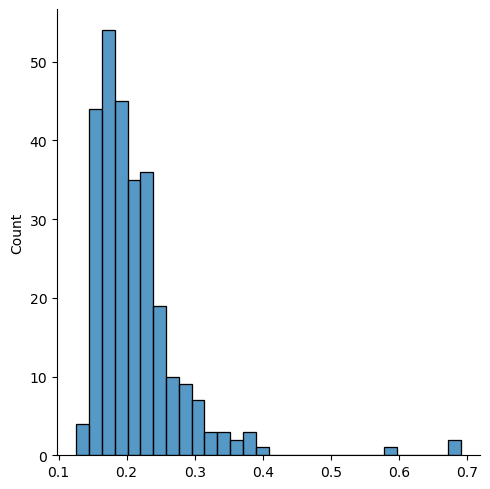

In [54]:
sns.displot(loss_scores)

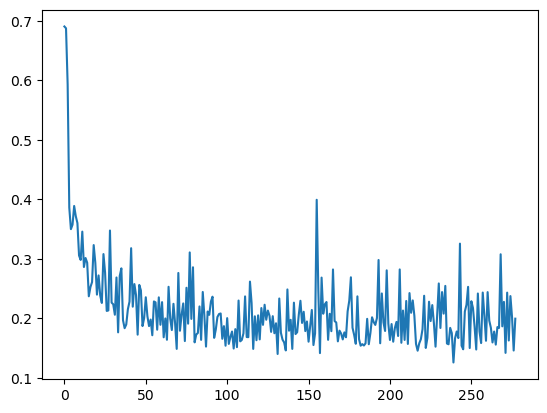

In [55]:
plt.plot(range(len(val_loss_scores)), loss_scores)

In [56]:
predictions = pd.DataFrame(columns=[str(i) for i in range(1296)])

test_path = Path('./images_test')

with torch.no_grad():
    for path in test_path.iterdir():
        # print(str(path).split('/')[1])
        img = torch.from_numpy(np.load(path)).unsqueeze(0).to(mps_device)
        name = str(path).split('/')[1].split('.')[0]
        pred = model(img.unsqueeze(0))
        pred = np.where(pred.cpu() >= 0.5, 1, 0).reshape(-1)
        predictions.loc[name] = pd.Series(pred, index=[str(i) for i in range(1296)])

print(predictions)
predictions.to_csv('predictions.csv')


                   0  1  2  3  4  5  6  7  8  9  ...  1286  1287  1288  1289  \
well_5_patch_1485  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_5_patch_567   0  0  0  0  0  0  0  0  0  1  ...     0     0     0     0   
well_5_patch_201   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     1   
well_3_patch_57    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_3_patch_419   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...               .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
well_3_patch_372   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_3_patch_414   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_3_patch_400   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_5_patch_218   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_3_patch_366   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

                   1290  1291  1292  12

: 